In [1]:
# data analysis and wragling
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# dates
import datetime
from matplotlib.dates import DateFormatter

# text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re

# statistical analysis
from scipy.stats import ttest_ind

[nltk_data] Downloading package punkt to C:\Users\Jason
[nltk_data]     Chong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pwd

'C:\\Users\\Jason Chong'

In [3]:
# import data

customerData = pd.read_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/QVI_purchase_behaviour.csv")
transactionData = pd.read_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/QVI_transaction_data.csv")

In [4]:
customerData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [5]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
len(transactionData)

264836

In [7]:
transactionData['TXN_ID'].nunique()

# Comment: 'TXN_ID' is not unique to each row which means a customer can buy multiple brands of chips in a single trasaction
# Each row of the data corresponds to purchase of a single brand of chips and a customer can buy multiple brands in one single transaction

263127

In [8]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


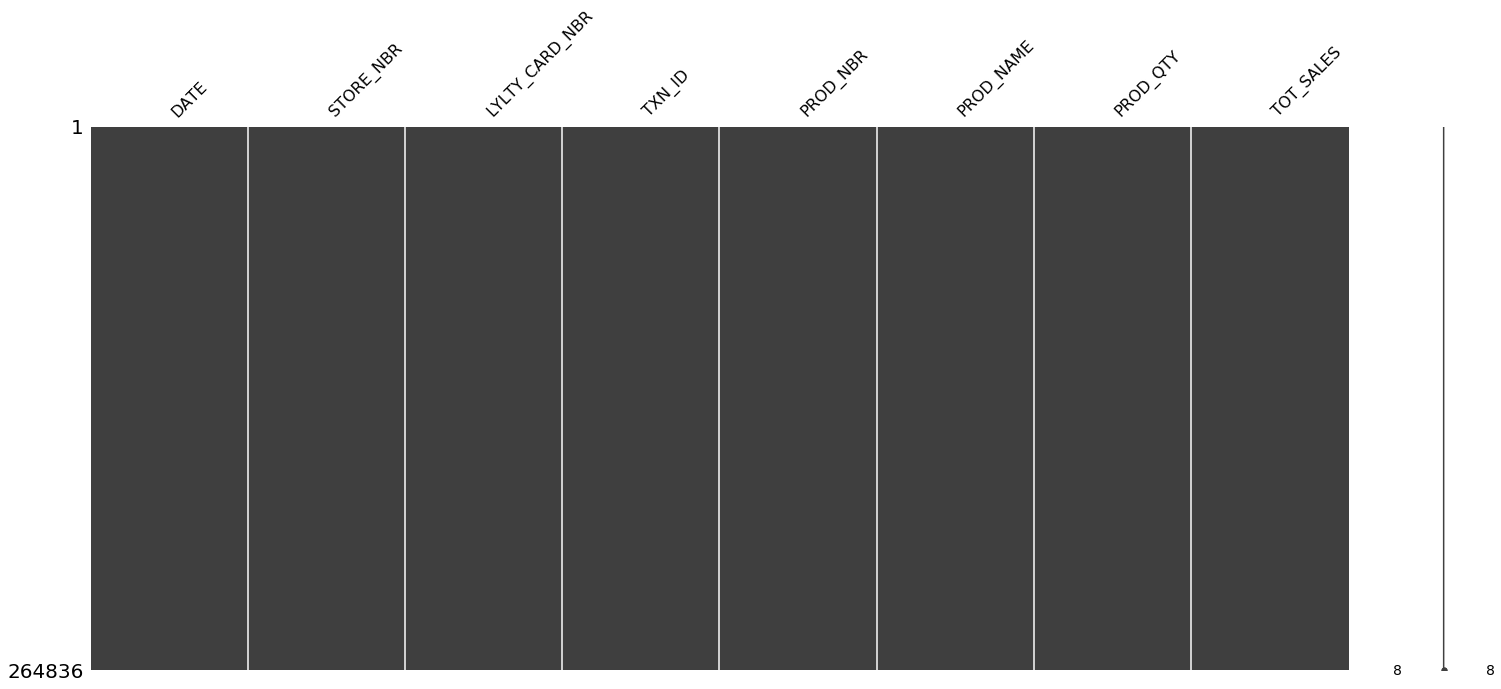

In [9]:
# Plot graph of missing values for 'transactionData'

missingno.matrix(transactionData)

# Comment: no missing numbers in transaction data 

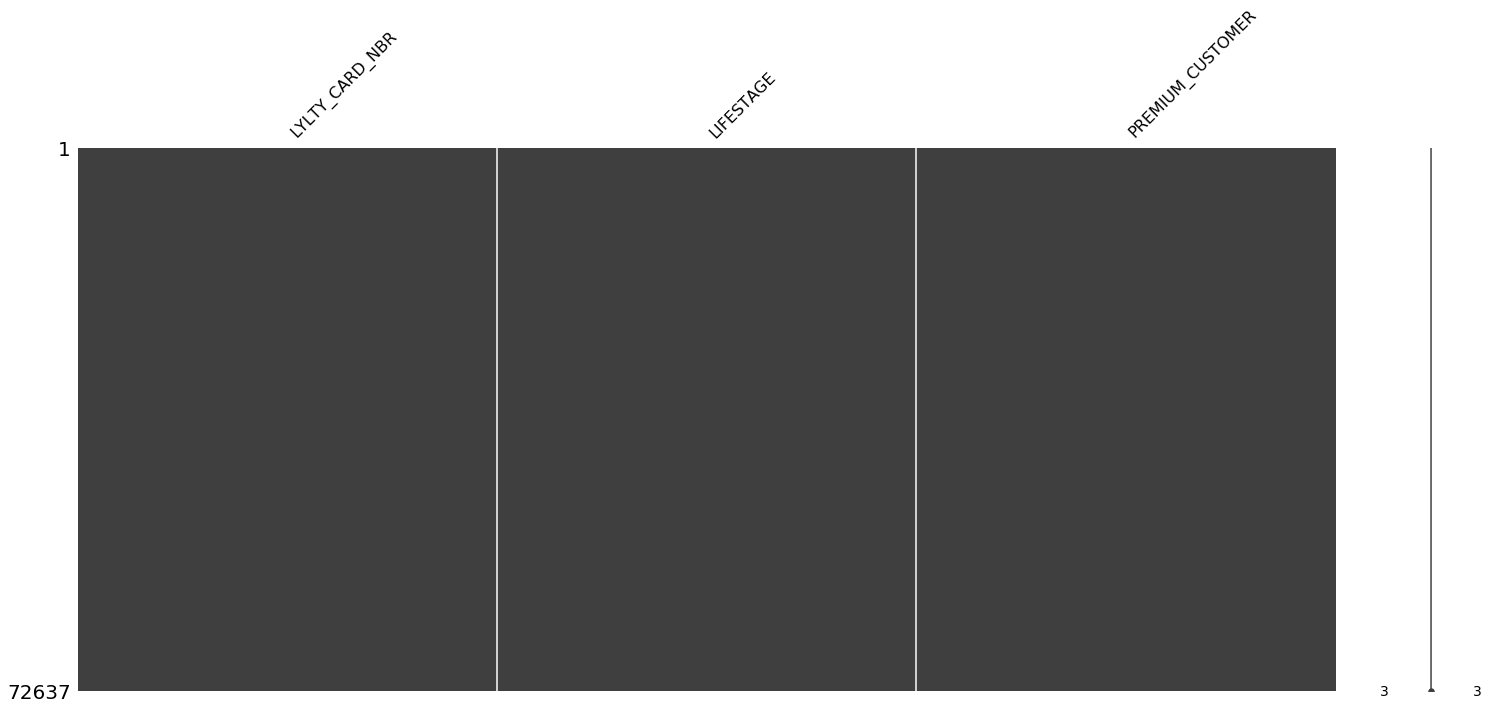

In [10]:
# Plot graph of missing values for 'customerData'

missingno.matrix(customerData)

# Comment: no missing values in customer data

In [11]:
# Now let's explore the features in both dataset starting with 'transactionData'

list(transactionData.columns)

['DATE',
 'STORE_NBR',
 'LYLTY_CARD_NBR',
 'TXN_ID',
 'PROD_NBR',
 'PROD_NAME',
 'PROD_QTY',
 'TOT_SALES']

In [12]:
transactionData.DATE.head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [13]:
# 'Date' is not in the right format

# Function that converts Excel integer into yyyy-mm-dd format
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

In [14]:
# Apply function to 'DATE' feature in 'transactionData' dataset

transactionData['newdate'] = transactionData.DATE.apply(xlseriesdate_to_datetime)

In [15]:
# Check the first 5 rows of the new feature

transactionData['newdate'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: newdate, dtype: datetime64[ns]

In [16]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,2018-10-17
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,2019-05-14
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,2019-05-20
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,2018-08-17
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,2018-08-18


In [17]:
# Let's move on to 'PROD_NAME' feature

transactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [18]:
# Extract weights out of 'PROD_NAME'

transactionData['pack_size'] = transactionData['PROD_NAME'].str.extract("(\d+)")
transactionData['pack_size'] = pd.to_numeric(transactionData['pack_size'])
transactionData['pack_size'].head()

0    175
1    175
2    170
3    175
4    150
Name: pack_size, dtype: int64

In [19]:
# Create text cleaning function for 'PROD_NAME' feature

def clean_text(text):
    text = text.lower() # to lowercase letters
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text

# Apply text cleaning function to 'PROD_NAME' column

transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(clean_text)

In [20]:
# Create one giant string and apply 'word_tokenize' to separate the words

prod_clean = transactionData['PROD_NAME']
string = ''.join(prod_clean)
prod_words = word_tokenize(string)

In [21]:
# Apply 'fdist' function which computes the frequency of each token and put it into a dataframe

word_freq = fdist(prod_words)
freq_df = pd.DataFrame(list(word_freq.items()), columns = ["Word","Frequency"]).sort_values(by = 'Frequency', ascending = False)

In [22]:
# Let's see the top 5 most frequent words

freq_df.head(10)

,Word,Frequency
10,chips,49770
16,kettle,40739
7,smiths,28572
6,cheese,27890
66,pringles,24743
28,salt,24719
34,doritos,24650
8,crinkle,23960
35,corn,22063
48,original,21560


In [23]:
# Drop rows with 'salsa' in 'PROD_NAME'

transactionData['PROD_NAME'] = transactionData['PROD_NAME'].apply(lambda x: x.lower())
transactionData = transactionData[~transactionData['PROD_NAME'].str.contains("salsa")]

In [24]:
# We have dropped 264836 - 246742 = 18094 rows in total

len(transactionData)

246742

In [25]:
# Let's have a look at our data table again

transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate,pack_size
0,43390,1,1000,1,5,natural chip compny seasalt,2,6.0,2018-10-17,175
1,43599,1,1307,348,66,ccs nacho cheese,3,6.3,2019-05-14,175
2,43605,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,2019-05-20,170
3,43329,2,2373,974,69,smiths chip thinly s cream onion,5,15.0,2018-08-17,175
4,43330,2,2426,1038,108,kettle tortilla chpshny jlpno chili,3,13.8,2018-08-18,150


In [26]:
# We shall explore 'PROD_QTY' and 'TOT_SALES' feature next

transactionData['PROD_QTY'].describe()

count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64

In [27]:
# Max of 200 looks odd

transactionData['PROD_QTY'].value_counts()

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

In [28]:
# We have two occurrences of 200 in the dataset
# Let's explore further

transactionData.loc[transactionData['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate,pack_size
69762,43331,226,226000,226201,4,dorito corn chp supreme,200,650.0,2018-08-19,380
69763,43605,226,226000,226210,4,dorito corn chp supreme,200,650.0,2019-05-20,380


In [29]:
# Both these transactions have been made by the same person at the same store
# Let's see all the transactions this person has made by tracking his loyalty card number '226000'

transactionData.loc[transactionData['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate,pack_size
69762,43331,226,226000,226201,4,dorito corn chp supreme,200,650.0,2018-08-19,380
69763,43605,226,226000,226210,4,dorito corn chp supreme,200,650.0,2019-05-20,380


In [30]:
# This person only made two transactions over the entire year so unlikely to be a retail customer 
# He or she is most likely purchasing for commercial purposes
# Safe to drop these this customer in both 'transactionData' and 'customerData' dataset

transactionData.drop(transactionData.index[transactionData['LYLTY_CARD_NBR'] == 226000], inplace = True)
customerData.drop(customerData.index[customerData['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [31]:
len(transactionData)

246740

In [32]:
# Now let's examine the number of transactions over time to see if there are any obvious data issues e.g. missing data

transactionData['newdate'].nunique()

364

In [33]:
transactionData.groupby('newdate').PROD_QTY.sum()

newdate
2018-07-01    1273
2018-07-02    1251
2018-07-03    1296
2018-07-04    1286
2018-07-05    1258
              ... 
2019-06-26    1251
2019-06-27    1276
2019-06-28    1288
2019-06-29    1355
2019-06-30    1342
Name: PROD_QTY, Length: 364, dtype: int64

In [34]:
# There seems to be one day missing out of the 365 days

transactionData['newdate'].value_counts().sort_index()

2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Name: newdate, Length: 364, dtype: int64

In [35]:
# Look for the missing date 
# Turns out that it was Christmas Day so it makes sense because most retail stores are closed on that day

pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(transactionData['newdate'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [36]:
# Create a new dataframe which contains the the number of transactions for each date

a = pd.pivot_table(transactionData, values = 'PROD_QTY', index = 'newdate', aggfunc = 'sum')
a.head()

,PROD_QTY
newdate,
2018-07-01,1273
2018-07-02,1251
2018-07-03,1296
2018-07-04,1286
2018-07-05,1258


In [37]:
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['PROD_QTY'] = 0
b

,PROD_QTY
2018-07-01,0
2018-07-02,0
2018-07-03,0
2018-07-04,0
2018-07-05,0
...,...
2019-06-26,0
2019-06-27,0
2019-06-28,0
2019-06-29,0


In [119]:
c = a+b
c.fillna(0, inplace = True)

In [39]:
c.head()

,PROD_QTY
2018-07-01,1273.0
2018-07-02,1251.0
2018-07-03,1296.0
2018-07-04,1286.0
2018-07-05,1258.0


In [120]:
c.index.name = 'Date'
c.rename(columns = {'PROD_QTY': 'Number of Chips Sold'}, inplace = True)
c.head() 

,Number of Chips Sold
Date,
2018-07-01,1273.0
2018-07-02,1251.0
2018-07-03,1296.0
2018-07-04,1286.0
2018-07-05,1258.0


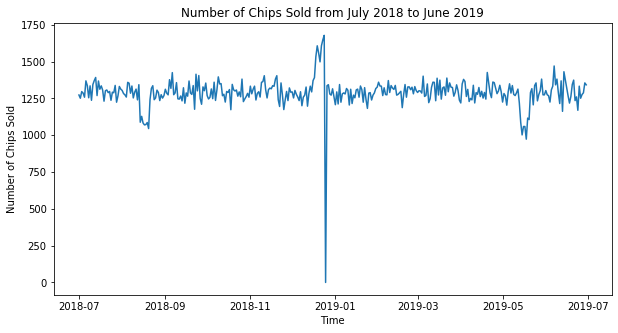

In [121]:
timeline = c.index
graph = c['Number of Chips Sold']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Number of Chips Sold from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Number of Chips Sold')

plt.show()

# Comment: We can see the number of chips sold spike up during the December month and zero sale on Christmas

In [42]:
# Confirm the date where sales count equals to zero

c[c['Number of Chips Sold'] == 0]

,Number of Chips Sold
Date,
2018-12-25,0.0


In [43]:
c.reset_index(inplace = True)
c.head()

,Date,Number of Chips Sold
0,2018-07-01,1273.0
1,2018-07-02,1251.0
2,2018-07-03,1296.0
3,2018-07-04,1286.0
4,2018-07-05,1258.0


In [44]:
c_december = c[(c.Date < "2019-01-01") & (c.Date > "2018-11-30")]
c_december.head()

,Date,Number of Chips Sold
153,2018-12-01,1294.0
154,2018-12-02,1253.0
155,2018-12-03,1304.0
156,2018-12-04,1278.0
157,2018-12-05,1259.0


In [45]:
len(c_december)

31

In [46]:
c_december.reset_index(drop = True, inplace = True)
c_december.head()

,Date,Number of Chips Sold
0,2018-12-01,1294.0
1,2018-12-02,1253.0
2,2018-12-03,1304.0
3,2018-12-04,1278.0
4,2018-12-05,1259.0


In [47]:
# Relabel 'Date'

c_december.Date = c_december.index + 1

C:\Users\Jason Chong\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
c_december.head()

,Date,Number of Chips Sold
0,1,1294.0
1,2,1253.0
2,3,1304.0
3,4,1278.0
4,5,1259.0


In [49]:
c_december.tail()

,Date,Number of Chips Sold
26,27,1343.0
27,28,1280.0
28,29,1272.0
29,30,1315.0
30,31,1261.0


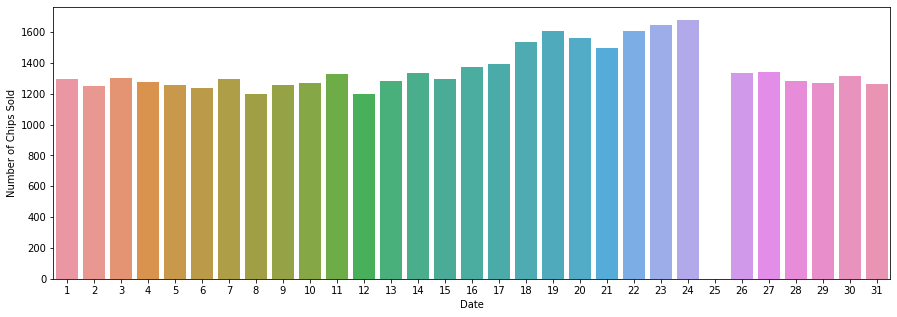

In [50]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Number of Chips Sold', data = c_december)

# Comment: No sales on Christmas Day (2018-12-25)

In [51]:
# Now that we are satisfied that the data no longer has outliers
# We can move on to creating other features
# At the beginning, we have already created a 'pack_size' feature
# Let's have a look again

transactionData['pack_size'].head()

0    175
1    175
2    170
3    175
4    150
Name: pack_size, dtype: int64

In [52]:
transactionData['pack_size'].unique()

# Comment: the largest size is 380g and the smallest size is 70g which seems reasonable

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70], dtype=int64)

In [53]:
# Compute number of sales for each pack size

packSales = transactionData[['pack_size', 'PROD_QTY']].groupby(['pack_size'], as_index = False).sum()
packSales.head()

,pack_size,PROD_QTY
0,70,2855
1,90,5692
2,110,42835
3,125,2730
4,134,48019


In [54]:
packSales.rename(columns = {'pack_size': 'Size', 'PROD_QTY': 'Quantity Sold'}, inplace = True)
packSales.sort_values(by = 'Size', inplace = True)
packSales

,Size,Quantity Sold
0,70,2855
1,90,5692
2,110,42835
3,125,2730
4,134,48019
5,135,6212
6,150,76662
7,160,5604
8,165,29051
9,170,38088


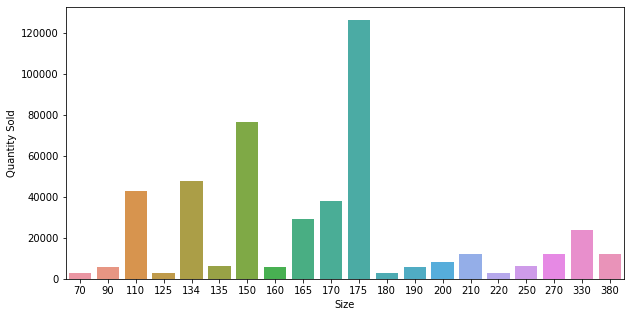

In [55]:
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Size', y = 'Quantity Sold', data = packSales)

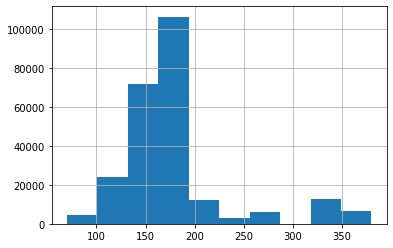

In [56]:
# Check to see if it corresponds to a simple histogram straight from the data

transactionData['pack_size'].hist()

In [57]:
# Extract brand name from 'PROD_NAME' 
# Create a new column under 'TransactionData' called 'brand'

part = transactionData['PROD_NAME'].str.partition()
transactionData['brand'] = part[0]
transactionData['brand'].head()

0    natural
1        ccs
2     smiths
3     smiths
4     kettle
Name: brand, dtype: object

In [58]:
transactionData['brand'].nunique()

28

In [59]:
transactionData['brand'].unique()

array(['natural', 'ccs', 'smiths', 'kettle', 'grain', 'doritos',
       'twisties', 'ww', 'thins', 'burger', 'ncc', 'cheezels', 'infzns',
       'red', 'pringles', 'dorito', 'infuzions', 'smith', 'grnwves',
       'tyrrells', 'cobs', 'french', 'rrd', 'tostitos', 'cheetos',
       'woolworths', 'snbts', 'sunbites'], dtype=object)

In [60]:
# It looks like there are duplicates of the same brand e.g. 'ww' and 'woolworths', 'red' and 'rrd', 'natural' and 'ncc', 
# 'infuzions' and 'infzns', 'snbts' and 'sunbites', 'grain' and 'grnwves', 'smiths' and 'smith', 'doritos' and 'dorito'
# Let's rename them for consistency

transactionData['brand'].replace(['natural', 'ncc'], 'Natural', inplace = True)
transactionData['brand'].replace('ccs', 'CCs', inplace = True)
transactionData['brand'].replace(['smiths', 'smith'], 'Smiths', inplace = True)
transactionData['brand'].replace('kettle', 'Kettle', inplace = True)
transactionData['brand'].replace(['grain', 'grnwves'], 'Natural', inplace = True)
transactionData['brand'].replace(['doritos', 'dorito'], 'Doritos', inplace = True)
transactionData['brand'].replace('twisties', 'Twisties', inplace = True)
transactionData['brand'].replace(['ww', 'woolworths'], 'Woolworths', inplace = True)
transactionData['brand'].replace('thins', 'Thins', inplace = True)
transactionData['brand'].replace('burger', 'Burger Rings', inplace = True)
transactionData['brand'].replace('cheezels', 'Cheezels', inplace = True)
transactionData['brand'].replace(['infzns', 'infuzions'], 'Infuzions', inplace = True)
transactionData['brand'].replace(['red', 'rrd'], 'Red Rock Deli', inplace = True)
transactionData['brand'].replace('pringles', 'Pringles', inplace = True)
transactionData['brand'].replace('tyrrells', 'Tyrrells', inplace = True)
transactionData['brand'].replace('cobs', 'Cobs', inplace = True)
transactionData['brand'].replace('french', 'French Fries', inplace = True)
transactionData['brand'].replace('tostitos', 'Tostitos', inplace = True)
transactionData['brand'].replace('cheetos', 'Cheetos', inplace = True)
transactionData['brand'].replace(['snbts', 'sunbites'], 'Sunbites', inplace = True)

transactionData.brand.unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Doritos', 'Twisties',
       'Woolworths', 'Thins', 'Burger Rings', 'Cheezels', 'Infuzions',
       'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs', 'French Fries',
       'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [61]:
# Which brand had the most sales?

transactionData.groupby('brand').TOT_SALES.sum().sort_values(ascending = False)

brand
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Natural           93935.2
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Woolworths        41059.1
Cheezels          40029.9
CCs               18078.9
Cheetos           16884.5
Sunbites           9676.4
French Fries       7929.0
Burger Rings       6831.0
Name: TOT_SALES, dtype: float64

In [62]:
# Create a dataframe 'brand_sales' for plotting purposes

brand_sales = transactionData.groupby('brand', as_index = False).TOT_SALES.sum()
brand_sales.rename(columns = {'brand': 'Brand', 'TOT_SALES': 'Annual Sales'}, inplace = True)
brand_sales.sort_values(by = 'Annual Sales', ascending = False, inplace = True)

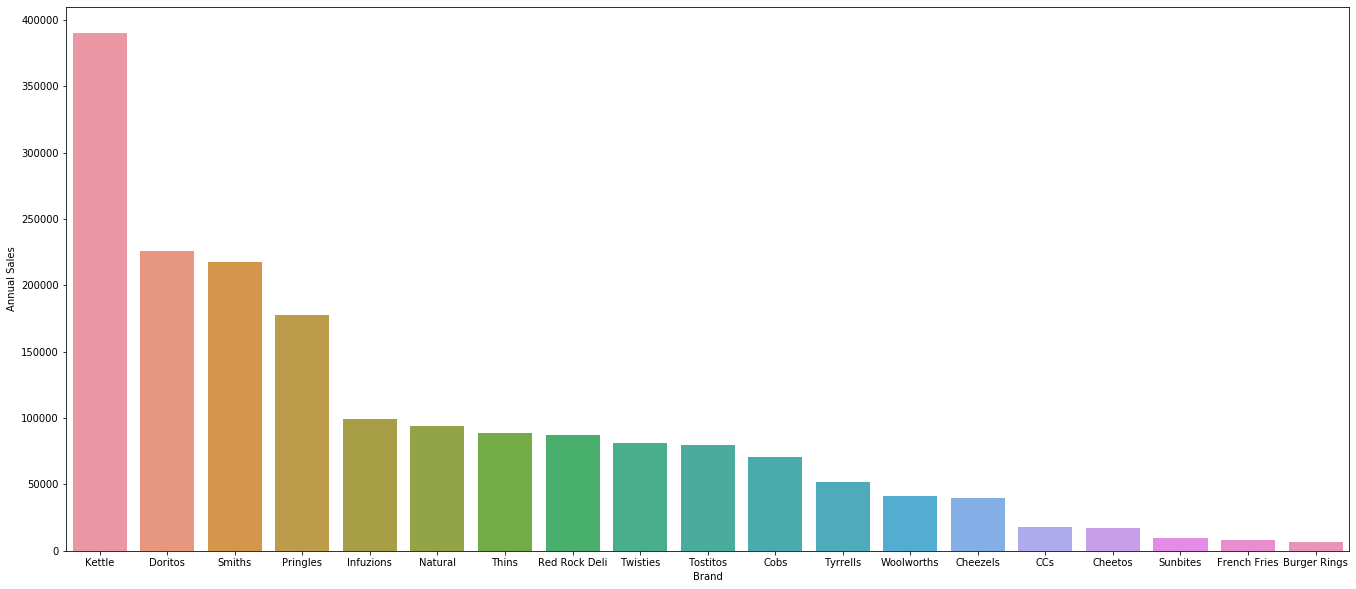

In [63]:
plt.figure(figsize = (23, 10))
sns.barplot(x = 'Brand', y = 'Annual Sales', data = brand_sales)

In [64]:
# Let's move on to 'customerData' dataset now

list(customerData.columns)

['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']

In [65]:
customerData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [66]:
len(customerData)

72636

In [67]:
customerData['LYLTY_CARD_NBR'].nunique()

# Comment: 'LYLTY_CARD_NBR' is unique to each row

72636

In [68]:
customerData['LIFESTAGE'].nunique()

# Comment: 7 unique lifestages of customers

7

In [69]:
# Let's see what those lifestages are

customerData['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [70]:
# Counts for each lifestages

customerData['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

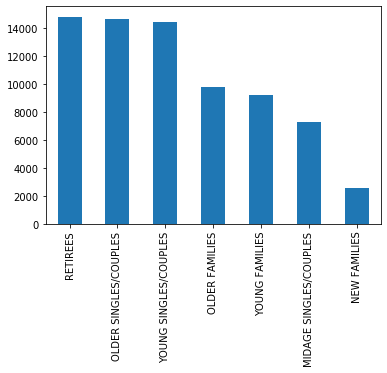

In [71]:
customerData['LIFESTAGE'].value_counts().plot(kind = 'bar')

In [72]:
# What about the 'PREMIUM_CUSTOMER' column

customerData['PREMIUM_CUSTOMER'].nunique()

3

In [73]:
# Counts for each 'PREMIUM_CUSTOMER'

customerData['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

# Comment: Mainstream has the highest count, followed by budget and finally premium

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

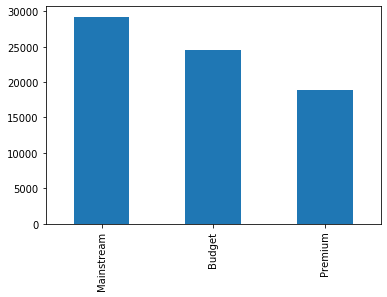

In [74]:
# Visualise the distribution of 'PREMIUM_CUSTOMER'

customerData['PREMIUM_CUSTOMER'].value_counts().plot(kind = 'bar')

In [75]:
# Now let's merge the two datasets together
# Before we do, examine the shape

transactionData.shape

(246740, 11)

In [76]:
customerData.shape

(72636, 3)

In [77]:
combineData = pd.merge(transactionData, customerData)
combineData.shape

(246740, 13)

In [78]:
# The two datasets are joined together via the column 'LYLTY_CARD_NBR'

combineData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate,pack_size,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,43390,1,1000,1,5,natural chip compny seasalt,2,6.0,2018-10-17,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,43599,1,1307,348,66,ccs nacho cheese,3,6.3,2019-05-14,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,43414,1,1307,346,96,ww original stacked chips,2,3.8,2018-11-10,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,43533,1,1307,347,54,ccs original,1,2.1,2019-03-09,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,43605,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,2019-05-20,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [79]:
# Check of null values

combineData.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
newdate             0
pack_size           0
brand               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [80]:
# Total sales by 'LIFESTAGE' from highest to lowest sales

combineData.groupby('LIFESTAGE').TOT_SALES.sum().sort_values(ascending = False)

LIFESTAGE
OLDER SINGLES/COUPLES     376019.65
RETIREES                  342381.90
OLDER FAMILIES            328519.90
YOUNG FAMILIES            294627.90
YOUNG SINGLES/COUPLES     243756.60
MIDAGE SINGLES/COUPLES    172523.80
NEW FAMILIES               47347.95
Name: TOT_SALES, dtype: float64

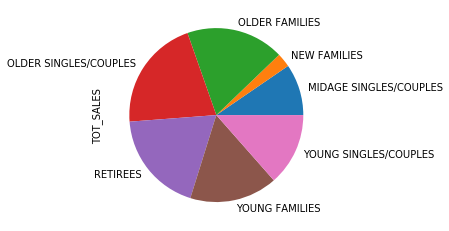

In [81]:
# Let's visualise this 

combineData.groupby('LIFESTAGE').TOT_SALES.sum().plot(kind = 'pie')

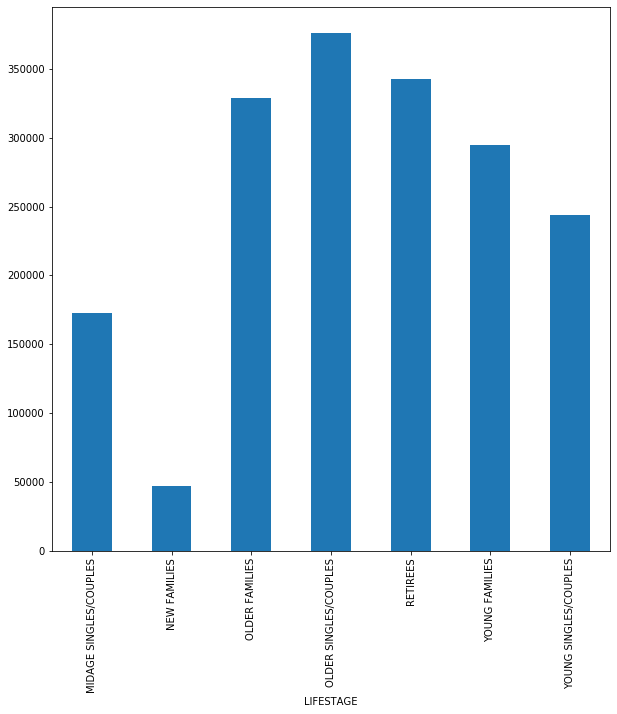

In [82]:
combineData.groupby('LIFESTAGE').TOT_SALES.sum().plot(kind = 'bar', figsize = (10, 10))

In [83]:
# Total sales by 'PREMIUM_CUSTOMER' from highest to lowest sale

combineData.groupby('PREMIUM_CUSTOMER').TOT_SALES.sum().sort_values(ascending = False)

PREMIUM_CUSTOMER
Mainstream    700865.40
Budget        631406.85
Premium       472905.45
Name: TOT_SALES, dtype: float64

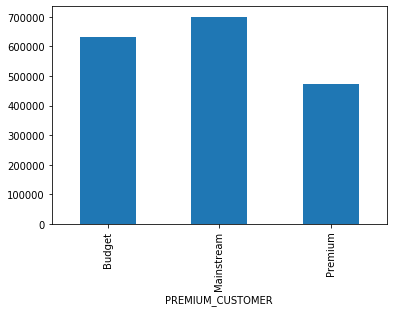

In [84]:
# Again, visualise this on a barplot

combineData.groupby('PREMIUM_CUSTOMER').TOT_SALES.sum().plot(kind = 'bar')                                                                                   

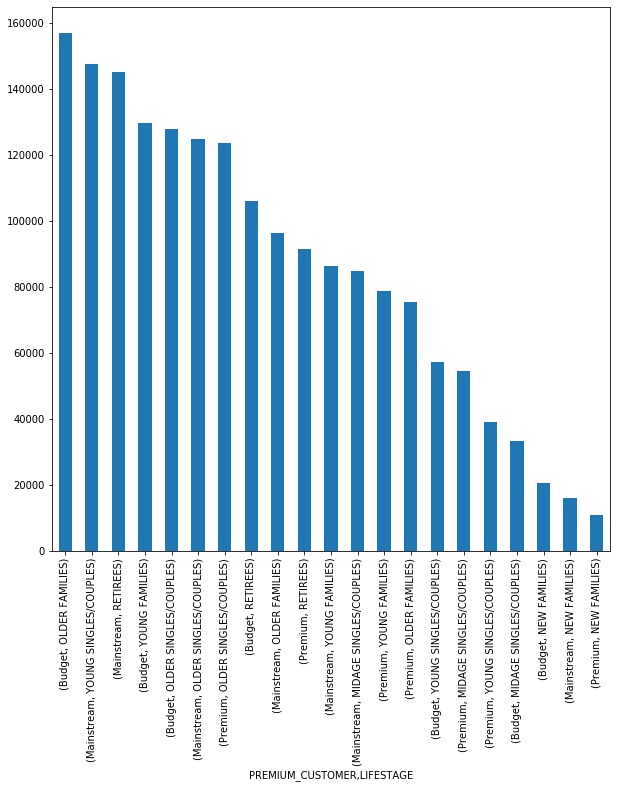

In [85]:
# Let's take this a step further
# Say we want to consider both features at the same time 

combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum().sort_values(ascending = False).plot(kind = 'bar', figsize = (10, 10))

In [86]:
# Let's examine if the higher sales are due to there being more customers who buy chips

combineData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate,pack_size,brand,LIFESTAGE,PREMIUM_CUSTOMER
0,43390,1,1000,1,5,natural chip compny seasalt,2,6.0,2018-10-17,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,43599,1,1307,348,66,ccs nacho cheese,3,6.3,2019-05-14,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,43414,1,1307,346,96,ww original stacked chips,2,3.8,2018-11-10,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,43533,1,1307,347,54,ccs original,1,2.1,2019-03-09,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,43605,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,2019-05-20,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


In [87]:
customer_segment = "(" + combineData['PREMIUM_CUSTOMER'] + ", " + combineData['LIFESTAGE'] + ")"
customer_segment.head()

0    (Premium, YOUNG SINGLES/COUPLES)
1    (Budget, MIDAGE SINGLES/COUPLES)
2    (Budget, MIDAGE SINGLES/COUPLES)
3    (Budget, MIDAGE SINGLES/COUPLES)
4    (Budget, MIDAGE SINGLES/COUPLES)
dtype: object

In [88]:
customer_number = combineData['LYLTY_CARD_NBR']
customer_number.head()

0    1000
1    1307
2    1307
3    1307
4    1343
Name: LYLTY_CARD_NBR, dtype: int64

In [89]:
list_of_tuples = list(zip(customer_number, customer_segment))
customer_profile = pd.DataFrame(list_of_tuples, columns = ['Customer Number', 'Customer Segment'])
customer_profile.head()

,Customer Number,Customer Segment
0,1000,"(Premium, YOUNG SINGLES/COUPLES)"
1,1307,"(Budget, MIDAGE SINGLES/COUPLES)"
2,1307,"(Budget, MIDAGE SINGLES/COUPLES)"
3,1307,"(Budget, MIDAGE SINGLES/COUPLES)"
4,1343,"(Budget, MIDAGE SINGLES/COUPLES)"


In [90]:
len(customer_profile)

246740

In [91]:
customer_profile.duplicated()

0         False
1         False
2          True
3          True
4         False
          ...  
246735     True
246736    False
246737    False
246738     True
246739    False
Length: 246740, dtype: bool

In [92]:
# Drop transactions from the same customer

customer_profile.drop_duplicates(keep = 'first', inplace = True)
customer_profile.duplicated()

0         False
1         False
4         False
5         False
6         False
          ...  
246732    False
246734    False
246736    False
246737    False
246739    False
Length: 71287, dtype: bool

In [93]:
customer_profile.head()

,Customer Number,Customer Segment
0,1000,"(Premium, YOUNG SINGLES/COUPLES)"
1,1307,"(Budget, MIDAGE SINGLES/COUPLES)"
4,1343,"(Budget, MIDAGE SINGLES/COUPLES)"
5,2373,"(Budget, MIDAGE SINGLES/COUPLES)"
6,2426,"(Budget, MIDAGE SINGLES/COUPLES)"


In [94]:
# Now group customers by 'Customer Segment'

customer_profile['Customer Segment'].value_counts()

(Mainstream, YOUNG SINGLES/COUPLES)     7917
(Mainstream, RETIREES)                  6358
(Mainstream, OLDER SINGLES/COUPLES)     4858
(Budget, OLDER SINGLES/COUPLES)         4849
(Premium, OLDER SINGLES/COUPLES)        4682
(Budget, OLDER FAMILIES)                4611
(Budget, RETIREES)                      4385
(Budget, YOUNG FAMILIES)                3953
(Premium, RETIREES)                     3812
(Budget, YOUNG SINGLES/COUPLES)         3647
(Mainstream, MIDAGE SINGLES/COUPLES)    3298
(Mainstream, OLDER FAMILIES)            2788
(Mainstream, YOUNG FAMILIES)            2685
(Premium, YOUNG SINGLES/COUPLES)        2480
(Premium, YOUNG FAMILIES)               2398
(Premium, MIDAGE SINGLES/COUPLES)       2369
(Premium, OLDER FAMILIES)               2231
(Budget, MIDAGE SINGLES/COUPLES)        1474
(Budget, NEW FAMILIES)                  1087
(Mainstream, NEW FAMILIES)               830
(Premium, NEW FAMILIES)                  575
Name: Customer Segment, dtype: int64

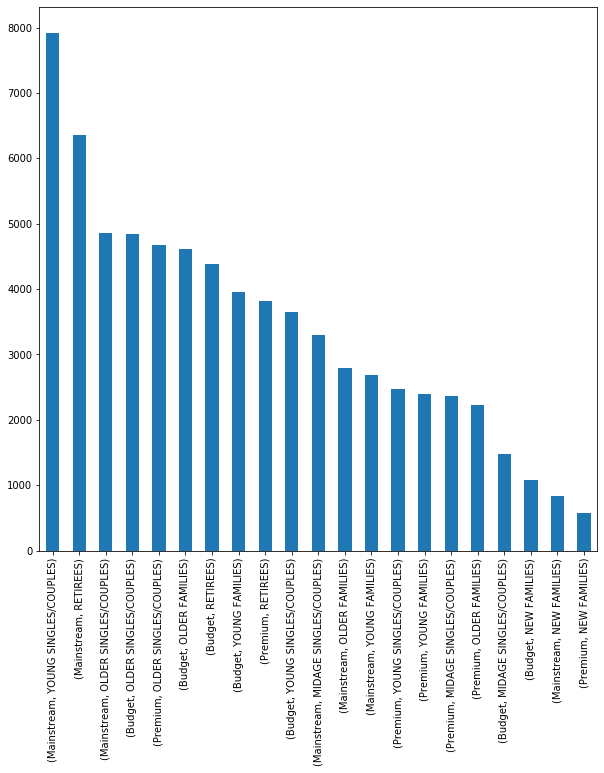

In [95]:
# Which segment has the most number of customers?

customer_profile['Customer Segment'].value_counts().plot(kind = 'bar', figsize = (10, 10))

In [96]:
# Recall our top 3 sales came from segments
# 1. (Budget, OLDER FAMILIES)
# 2. (Mainstream, YOUNG SINGLES/COUPLES)
# 3. (Mainstream, RETIREES)

# Comment: There are more (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) who buy chips 
# This contributes to there being more sales in these segments
# But this is not the main driver for (Budget, OLDER FAMILIES) segment

In [97]:
# Higher sales may also be driven by more units of chips being bought per customer
# Let's calculate the average number of units in each customer segment
# Create two new features 'Customer Profile' and 'Price per Unit'

combineData['Customer Profile'] = customer_segment
combineData['Price per Unit'] = combineData['TOT_SALES']/combineData['PROD_QTY']
combineData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,newdate,pack_size,brand,LIFESTAGE,PREMIUM_CUSTOMER,Customer Profile,Price per Unit
0,43390,1,1000,1,5,natural chip compny seasalt,2,6.0,2018-10-17,175,Natural,YOUNG SINGLES/COUPLES,Premium,"(Premium, YOUNG SINGLES/COUPLES)",3.00
1,43599,1,1307,348,66,ccs nacho cheese,3,6.3,2019-05-14,175,CCs,MIDAGE SINGLES/COUPLES,Budget,"(Budget, MIDAGE SINGLES/COUPLES)",2.10
2,43414,1,1307,346,96,ww original stacked chips,2,3.8,2018-11-10,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,"(Budget, MIDAGE SINGLES/COUPLES)",1.90
3,43533,1,1307,347,54,ccs original,1,2.1,2019-03-09,175,CCs,MIDAGE SINGLES/COUPLES,Budget,"(Budget, MIDAGE SINGLES/COUPLES)",2.10
4,43605,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,2019-05-20,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,"(Budget, MIDAGE SINGLES/COUPLES)",1.45


In [98]:
combineData.groupby('Customer Profile')['Price per Unit'].mean().sort_values(ascending = False)

# Comment: Mainstream midage and mainstream young singles and couples are more wiling to pay more per packet of chips compared to their budget and premium counterparts
# This may be due to premium shoppers being more likely to buy healthy snacks
# This statement is supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts

Customer Profile
(Mainstream, YOUNG SINGLES/COUPLES)     4.065642
(Mainstream, MIDAGE SINGLES/COUPLES)    3.994241
(Budget, RETIREES)                      3.924404
(Premium, RETIREES)                     3.920942
(Budget, NEW FAMILIES)                  3.917688
(Mainstream, NEW FAMILIES)              3.916133
(Premium, OLDER SINGLES/COUPLES)        3.893182
(Budget, OLDER SINGLES/COUPLES)         3.882096
(Premium, NEW FAMILIES)                 3.872110
(Mainstream, RETIREES)                  3.844294
(Mainstream, OLDER SINGLES/COUPLES)     3.814665
(Premium, MIDAGE SINGLES/COUPLES)       3.770698
(Premium, YOUNG FAMILIES)               3.762150
(Budget, YOUNG FAMILIES)                3.760737
(Budget, OLDER FAMILIES)                3.745340
(Budget, MIDAGE SINGLES/COUPLES)        3.743328
(Mainstream, OLDER FAMILIES)            3.737077
(Mainstream, YOUNG FAMILIES)            3.724533
(Premium, OLDER FAMILIES)               3.717000
(Premium, YOUNG SINGLES/COUPLES)        3.665414
(Bu

In [99]:
# As this difference in average price per unit is not too large 
# Let's test for statistical significance using the t-test between mainstream vs premium for
# 1. Midage singles/couples
# 2. Young singles/couples

mainstream_midage = combineData.loc[combineData['Customer Profile'] == '(Mainstream, MIDAGE SINGLES/COUPLES)', 'Price per Unit']
premium_budget_midage = combineData.loc[(combineData['Customer Profile'] == '(Premium, MIDAGE SINGLES/COUPLES)') | (combineData['Customer Profile'] == '(Budget, MIDAGE SINGLES/COUPLES)'), 'Price per Unit']

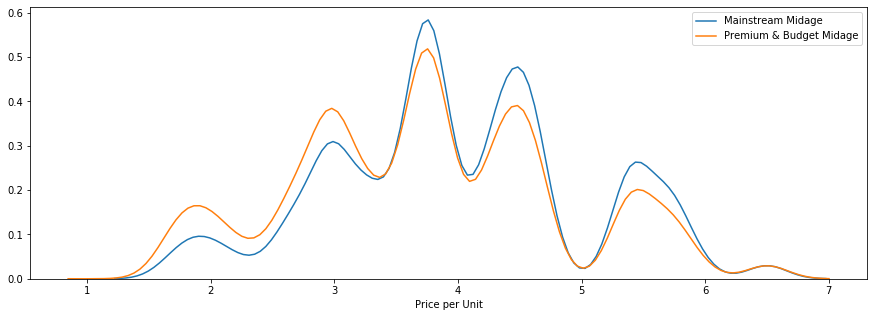

In [100]:
plt.figure(figsize = (15, 5))
sns.distplot(mainstream_midage, hist = False, label = 'Mainstream Midage')
sns.distplot(premium_budget_midage, hist = False, label = 'Premium & Budget Midage')
plt.show()

In [101]:
# Perform unpaired two-sample t-test on midage segment

ttest_ind(mainstream_midage, premium_budget_midage)

# Since the p-value is less than 0.05, we would reject the null hypothesis and conclude that there is statistically significant difference between the two samples

Ttest_indResult(statistic=16.81498310271437, pvalue=4.449929958809599e-63)

In [102]:
# Let's move on to compare young singles and couple under mainstream vs premium and budget

mainstream_young = combineData.loc[combineData['Customer Profile'] == '(Mainstream, YOUNG SINGLES/COUPLES)', 'Price per Unit']
premium_budget_young = combineData.loc[(combineData['Customer Profile'] == '(Premium, YOUNG SINGLES/COUPLES)') | (combineData['Customer Profile'] == '(Budget, YOUNG SINGLES/COUPLES)'), 'Price per Unit']

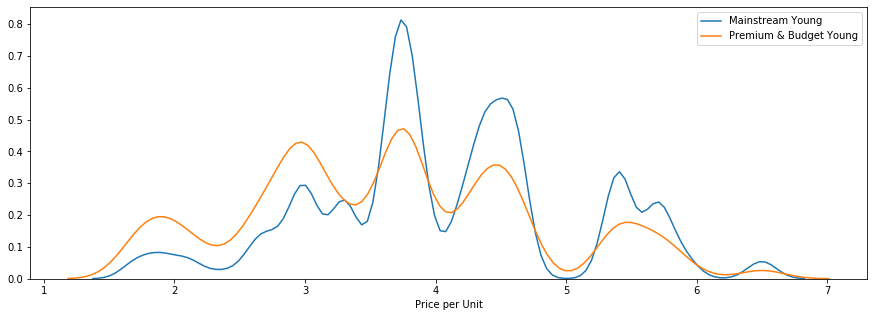

In [103]:
plt.figure(figsize = (15, 5))
sns.distplot(mainstream_young, hist = False, label = 'Mainstream Young')
sns.distplot(premium_budget_young, hist = False, label = 'Premium & Budget Young')
plt.show()

In [104]:
# Perform unpaired two-sample t-test on young segment

ttest_ind(mainstream_young, premium_budget_young)

# Comment: P-value also less than 0.05 so reject null hypothesis and confirm that there is statistically significant difference between the two samples

Ttest_indResult(statistic=35.33923272407983, pvalue=1.0984949314590198e-268)

In [105]:
# Deep dive into specific customer segment for insights
# We have found quite a few interesting insights that we can dive deeper into 
# For example, we might want to target customers segments that contribute the most to sales to retain them to further increase sales
# Let's examine mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips

target_segment = combineData.loc[combineData['Customer Profile'] == '(Mainstream, YOUNG SINGLES/COUPLES)', ['brand', 'TOT_SALES', 'pack_size']]
target_segment.head()

,brand,TOT_SALES,pack_size
221345,Smiths,2.6,150
221346,Smiths,5.7,330
221347,Natural,3.1,180
221348,Kettle,5.4,175
221349,Natural,3.0,175


In [106]:
other_segments = combineData.loc[combineData['Customer Profile'] != '(Mainstream, YOUNG SINGLES/COUPLES)', ['brand', 'TOT_SALES', 'pack_size']]
other_segments.head()

,brand,TOT_SALES,pack_size
0,Natural,6.0,175
1,CCs,6.3,175
2,Woolworths,3.8,160
3,CCs,2.1,175
4,Smiths,2.9,170


In [107]:
# Create dataframe which categorises sales by brand for (Mainstream, YOUNG SINGLES/COUPLES)segment

brand_target_segment = pd.DataFrame(target_segment.groupby('brand').TOT_SALES.sum())
brand_target_segment.index.rename('Brand', inplace = True)
brand_target_segment.rename(columns = {'TOT_SALES': 'Annual Sales (Target Segment)'}, inplace = True)
target_total_sale = brand_target_segment['Annual Sales (Target Segment)'].sum() # Total annual sale
brand_target_segment['Percentage of Sales (Target Segment)'] = brand_target_segment['Annual Sales (Target Segment)']/target_total_sale
brand_target_segment

,Annual Sales (Target Segment),Percentage of Sales (Target Segment)
Brand,,
Burger Rings,243.8,0.001652
CCs,850.5,0.005763
Cheetos,898.8,0.006090
Cheezels,3318.3,0.022484
Cobs,6144.6,0.041635
Doritos,20925.9,0.141791
French Fries,429.0,0.002907
Infuzions,8749.4,0.059285
Kettle,35423.6,0.240026


In [108]:
# Create dataframe which counts the number of transactions by 'pack_size' for mainstrema young singles/couples segment

packsize_target_segment = pd.DataFrame(target_segment.groupby('pack_size').TOT_SALES.count())
packsize_target_segment.index.rename('Pack Size', inplace = True)
packsize_target_segment.rename(columns = {'TOT_SALES': 'Number of Transactions (Target Segment)'}, inplace = True)
packsize_target_segment['Percentage of Transactions (Target Segment)'] = packsize_target_segment['Number of Transactions (Target Segment)']/len(target_segment)
packsize_target_segment

,Number of Transactions (Target Segment),Percentage of Transactions (Target Segment)
Pack Size,,
70,63,0.003223
90,128,0.006549
110,2051,0.104943
125,59,0.003019
134,2315,0.118451
135,290,0.014838
150,3080,0.157593
160,128,0.006549
165,1102,0.056386


In [109]:
# Now we do the same for the 'other_segments'
# First, dataframe for annual sales by each brand of chips

brand_other_segments = pd.DataFrame(other_segments.groupby('brand').TOT_SALES.sum())
brand_other_segments.index.rename('Brand', inplace = True)
brand_other_segments.rename(columns = {'TOT_SALES': 'Annual Sales (Other Segments)'}, inplace = True)
others_total_sale = brand_other_segments['Annual Sales (Other Segments)'].sum()
brand_other_segments['Percentage of Sales (Other Segments)'] = brand_other_segments['Annual Sales (Other Segments)']/others_total_sale
brand_other_segments

,Annual Sales (Other Segments),Percentage of Sales (Other Segments)
Brand,,
Burger Rings,6587.2,0.003974
CCs,17228.4,0.010394
Cheetos,15985.7,0.009644
Cheezels,36711.6,0.022148
Cobs,64425.2,0.038867
Doritos,205404.0,0.123917
French Fries,7500.0,0.004525
Infuzions,90298.2,0.054475
Kettle,354816.2,0.214055


In [110]:
# Next, number of transactions for each 'pack_size' for 'other_segments'

packsize_other_segments = pd.DataFrame(other_segments.groupby('pack_size').TOT_SALES.count())
packsize_other_segments.index.rename('Pack Size', inplace = True)
packsize_other_segments.rename(columns = {'TOT_SALES': 'Number of Sales (Other Segments)'}, inplace = True)
packsize_other_segments['Percentage of Transactions (Other Segments)'] = packsize_other_segments['Number of Sales (Other Segments)']/len(other_segments)
packsize_other_segments

,Number of Sales (Other Segments),Percentage of Transactions (Other Segments)
Pack Size,,
70,1444,0.006356
90,2880,0.012676
110,20336,0.089509
125,1395,0.006140
134,22787,0.100297
135,2967,0.013059
150,37123,0.163396
160,2842,0.012509
165,14195,0.062479


In [111]:
# Merge the two sales dataframe together

brand_combine = pd.merge(brand_target_segment, brand_other_segments, left_index = True, right_index = True)
brand_combine.head()

,Annual Sales (Target Segment),Percentage of Sales (Target Segment),Annual Sales (Other Segments),Percentage of Sales (Other Segments)
Brand,,,,
Burger Rings,243.8,0.001652,6587.2,0.003974
CCs,850.5,0.005763,17228.4,0.010394
Cheetos,898.8,0.006090,15985.7,0.009644
Cheezels,3318.3,0.022484,36711.6,0.022148
Cobs,6144.6,0.041635,64425.2,0.038867


In [112]:
# Create new feature called 'brand_affinity' 
# 'Affinity to Brand' greater than one implies 'target_segment' is more likely to purchase than the rest of the segments

brand_combine['Affinity to Brand'] = brand_combine['Percentage of Sales (Target Segment)']/brand_combine['Percentage of Sales (Other Segments)']
brand_combine.sort_values(by = 'Affinity to Brand', ascending = False)

# Comment: target segment is 15% more likely than the rest of the customer segments to purchase 'Tyrrells'

,Annual Sales (Target Segment),Percentage of Sales (Target Segment),Annual Sales (Other Segments),Percentage of Sales (Other Segments),Affinity to Brand
Brand,,,,,
Tyrrells,4800.6,0.032528,46846.8,0.028262,1.150960
Twisties,7539.8,0.051089,73982.3,0.044632,1.144660
Doritos,20925.9,0.141791,205404.0,0.123917,1.144247
Kettle,35423.6,0.240026,354816.2,0.214055,1.121331
Tostitos,7238.0,0.049044,72551.6,0.043769,1.120511
Pringles,16006.2,0.108456,161649.3,0.097520,1.112139
Infuzions,8749.4,0.059285,90298.2,0.054475,1.088288
Cobs,6144.6,0.041635,64425.2,0.038867,1.071229
Cheezels,3318.3,0.022484,36711.6,0.022148,1.015212


In [113]:
# We repeat this process for 'Pack Size'
# Merge the two dataframes together

packsize_combine = pd.merge(packsize_target_segment, packsize_other_segments, left_index = True, right_index = True)
packsize_combine

,Number of Transactions (Target Segment),Percentage of Transactions (Target Segment),Number of Sales (Other Segments),Percentage of Transactions (Other Segments)
Pack Size,,,,
70,63,0.003223,1444,0.006356
90,128,0.006549,2880,0.012676
110,2051,0.104943,20336,0.089509
125,59,0.003019,1395,0.006140
134,2315,0.118451,22787,0.100297
135,290,0.014838,2967,0.013059
150,3080,0.157593,37123,0.163396
160,128,0.006549,2842,0.012509
165,1102,0.056386,14195,0.062479


In [114]:
# Create new feature 'Affinity to Pack Size'

packsize_combine['Affinity to Pack Size'] = packsize_combine['Percentage of Transactions (Target Segment)']/packsize_combine['Percentage of Transactions (Other Segments)']
packsize_combine.sort_values(by = 'Affinity to Pack Size', ascending = False)                                                                                                                            

,Number of Transactions (Target Segment),Percentage of Transactions (Target Segment),Number of Sales (Other Segments),Percentage of Transactions (Other Segments),Affinity to Pack Size
Pack Size,,,,,
270,620,0.031723,5665,0.024934,1.272269
380,626,0.032030,5790,0.025485,1.256849
330,1195,0.061144,11345,0.049935,1.224477
134,2315,0.118451,22787,0.100297,1.181003
210,576,0.029472,5696,0.025071,1.175546
110,2051,0.104943,20336,0.089509,1.172431
135,290,0.014838,2967,0.013059,1.136234
250,280,0.014327,2889,0.012716,1.126673
170,1575,0.080587,18408,0.081023,0.994629


In [115]:
# Comment: target segment is most likely to purchase 270g
# Let's examine what is product is 

combineData.loc[combineData['pack_size'] == 270, 'PROD_NAME'].head(10)

34     twisties cheese      
79         twisties chicken 
125    twisties cheese      
132        twisties chicken 
209    twisties cheese      
252        twisties chicken 
253        twisties chicken 
278    twisties cheese      
347        twisties chicken 
350        twisties chicken 
Name: PROD_NAME, dtype: object

In [116]:
# It appears to be only 'Twisties' sell pack size in 270g

combineData.loc[combineData['pack_size'] == 270, 'brand'].unique()

# Comment: this explains the high 'Twisties' sale amongst the target segment

array(['Twisties'], dtype=object)

In [117]:
# Save 'combineData' for further uses

# combineData.to_csv("C:/Users/Jason Chong/Documents/Inside Sherpa Quantium/combineData.csv")

# Conclusion

- Sales are highest for (Budget, OLDER FAMILIES), (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES)
- We found that (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) are mainly due to the fact that there are more customers in these segments
- (Mainstream, YOUNG SINGLES/COUPLES) are more likely to pay more per packet of chips than their premium and budget counterparts
- They are also more likely to purchase 'Tyrrells' and '270g' pack sizes than the rest of the population

# Recommendation

The category manager may consider off-locating 'Tyrrells' chips in discretionary space near segments where young singles and couples frequent to increase the visibility and impulse behaviour